<a href="https://colab.research.google.com/github/SmrithiCh/PRA3024-/blob/main/PRA3024_Gravitational_Waves_W2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pycbc
! pip install -q 'gwpy==3.0.8'

# **Set 1**: Challenge 1

## Question 1: Loading Data & Data Duration + Sample Rate

In [ ]:
#loading data into memory on pyCBC
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

#loading data into memory on gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge1.gwf', channel="H1:CHALLENGE1")

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [ ]:
print("Sample Rate:",pycbc_strain.get_sample_rate())
print("Duration:",pycbc_strain.get_duration())

Sample Rate: 4096.0
Duration: 128.0


## Question 2: Plotting Data in Time Domain

Text(0.5, 1.0, 'Data in Time-Domain')

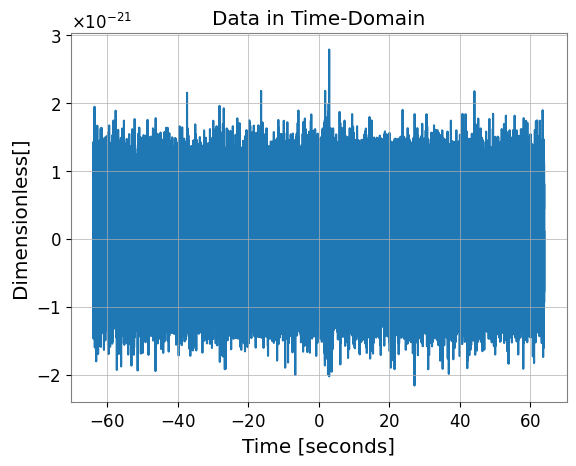

In [ ]:
import matplotlib.pyplot as plt
plot = pycbc_strain.plot()
plt.xlabel('Time [seconds]')
plt.ylabel('Dimensionless[]')
plt.title('Data in Time-Domain')

## Question 3: Identifying the Signal

### Using Spectrograms

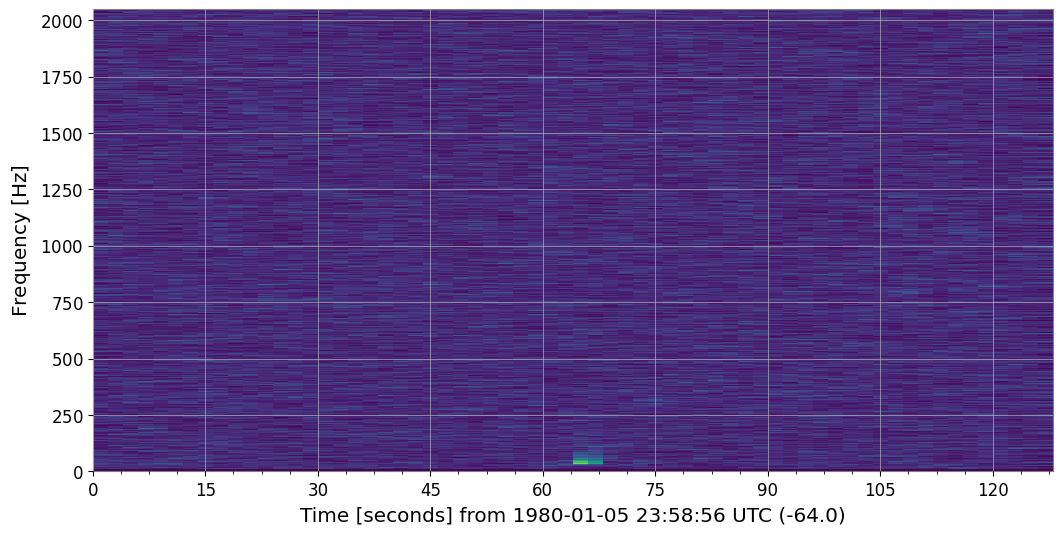

In [ ]:
specgram = gwpy_strain.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

#### There seems to be a signal between 63.75 and 67.5 seconds, but it's not very clear

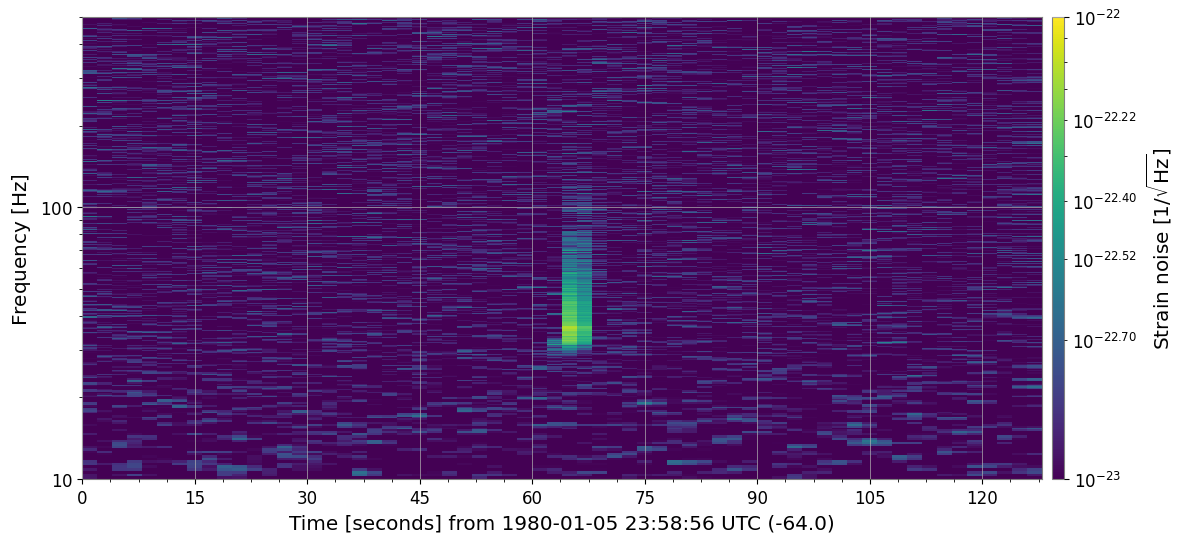

In [ ]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 500)
ax.colorbar(
    clim=(1e-23, 1e-22),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot

#### Still not clear enough, another method needs to be used

### Using Q-Transform

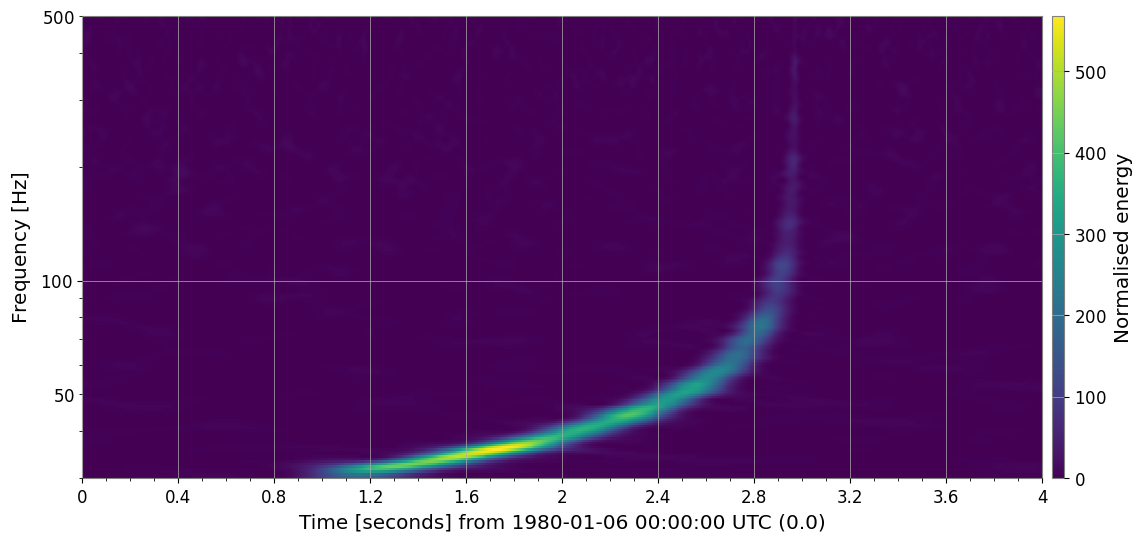

In [ ]:
q1 = gwpy_strain.q_transform(frange=(30, 500), qrange=(20, 200),outseg=(0,4))
plot = q1.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

## Question 4: Time of Merger

#### Time of merger as visible in the plot above is at **3.0 seconds after UTC (0.0)**

# **Set 1**: Challenge 2

In [ ]:
pycbc_strain2 = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
gwpy_strain2 = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

## Question 1: Time of Merger Estimate Using Q-Transform

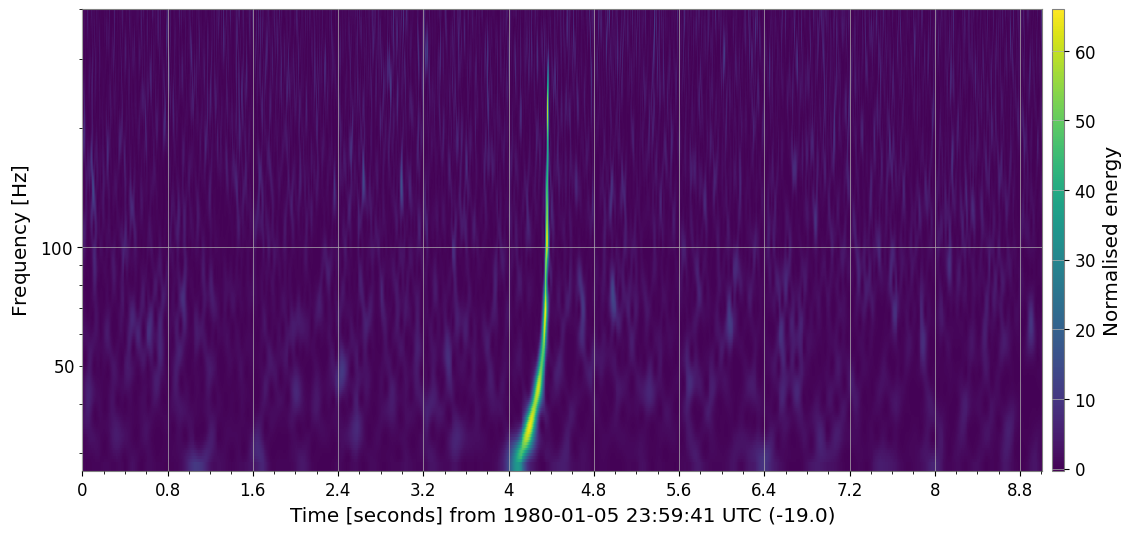

In [ ]:
q2 = gwpy_strain2.q_transform(frange=(27, 400), qrange=(10, 100),outseg=(-19,-10))
plot = q2.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

#### Time of merger as visible in the plot above is at **4.4 seconds after UTC (-19.0)**

## Question 2: Time-Domain Template Waveform Using "SEOBNRv4_opt"

In [ ]:
from pycbc.waveform import get_td_waveform
import pylab

In [ ]:
sample_rate = pycbc_strain2.get_sample_rate()
print("Sample Rate:",sample_rate)

Sample Rate: 4096.0


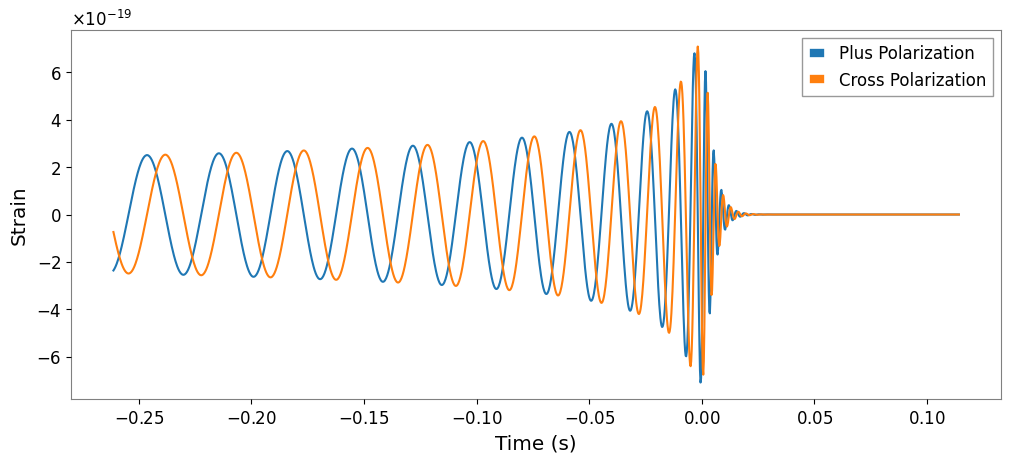

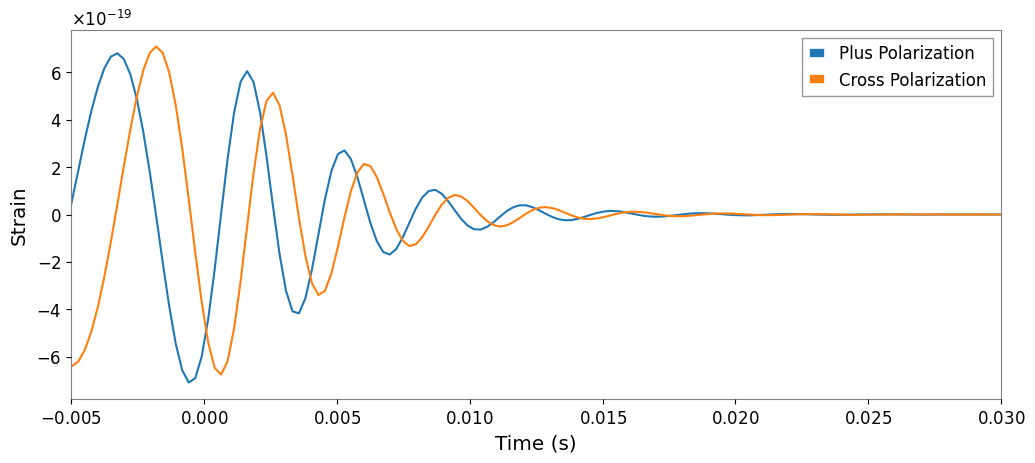

In [ ]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=30)
#spin not included here as it is 0. Moreover, the approximant cannot compute a non-zero spin.


pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.005, .03)
pylab.legend()
pylab.grid()
pylab.show()

### Question 3: Plot PSD

In [ ]:
nyquist_f = sample_rate/2
print("Nyquist Frequency:",nyquist_f)

Nyquist Frequency: 2048.0


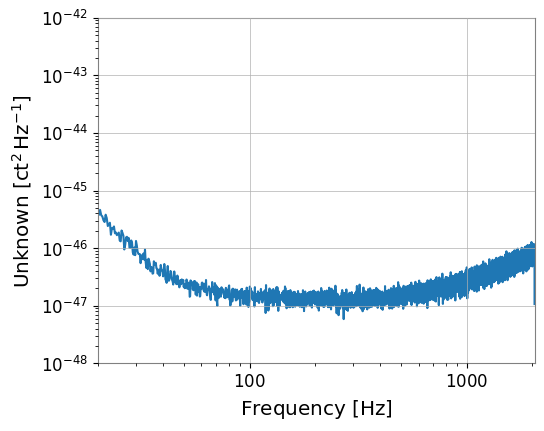

In [ ]:
psd = gwpy_strain2.psd(fftlength=4, method="median")
plotpsd = psd.plot()
ax = plotpsd.gca()
ax.set_xlim(20, nyquist_f)
ax.set_xscale("log")
ax.set_ylim(1e-48, 1e-42)
ax.set_yscale("log")

### Question 4: Calculating the SNR time series

In [ ]:

from pycbc.waveform import get_td_waveform

delta_t = 1.0/sample_rate
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=30,
                     mass2=30,
                     delta_t= delta_t,
                     f_lower=20)

# Resize the vector to match our data
#hp.resize(len(conditioned))